---------------- CHANGE RUNTIME TO GPU--------------------

---------------- CHANGE RUNTIME TO GPU--------------------

---------------- CHANGE RUNTIME TO GPU--------------------

---------------- CHANGE RUNTIME TO GPU--------------------

---------------- CHANGE RUNTIME TO GPU--------------------

In [ ]:
# the images are stored in google drive, we need to mount it to access the data.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# to get rid of nn.Upsample error (interplolate dafault behavior)
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 4.0MB 35.1MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [ ]:
from fastai import *
from fastai.vision import *
from pathlib import Path

In [ ]:
# path to parent folder
data_path = '/content/drive/My Drive/Colab Notebooks/Chest X-Ray Classification'

# Getting data for all 6 classes and training

In [ ]:
classes = ['Bacterial Pneumonia','COVID-19','Normal','Other Findings','TB','Viral Pneumonia']

In [ ]:
# getting the image file names from each folder (category)

total = 0
for cls in classes:
  path = data_path + '/' + cls
  fnames = get_image_files(path)
  print("We have", len(fnames),"CXR images of type", cls)
  total+= len(fnames)
print("We have",total,"images in total.")

We have 2530 CXR images of type Bacterial Pneumonia
We have 288 CXR images of type COVID-19
We have 1122 CXR images of type Normal
We have 5597 CXR images of type Other Findings
We have 394 CXR images of type TB
We have 1345 CXR images of type Viral Pneumonia
We have 11276 images in total.


It seems we have an imbalanced category-wise distribution of images. 'Other Findings' has about 5500 images, but COVID-19 has less than 300 images.

(Later, we will take care of this by augmenting the data for under-represented classes, and decreasing the number of images of over-represented classes.)

In [ ]:
# creating the ImagedataBunch
np.random.seed(42)
data = ImageDataBunch.from_folder(data_path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Bacterial Pneumonia',
  'COVID-19',
  'Normal',
  'Other Findings',
  'TB',
  'Viral Pneumonia'],
 6,
 9021,
 2255)

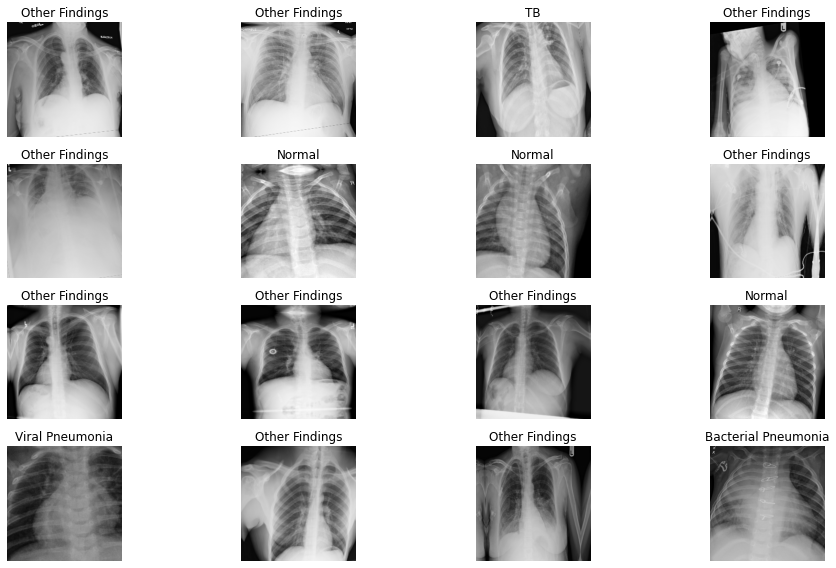

In [ ]:
data.show_batch(rows=4, figsize=(14,8))

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics = [accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.740564,0.447471,0.849667,0.150333,26:42
1,0.485865,0.331255,0.866962,0.133038,09:05
2,0.375516,0.339502,0.859867,0.140133,09:04
3,0.337040,0.300028,0.875388,0.124612,09:06


'error_rate' has not yet started increasing erratically. Also, training loss is still more than validation loss. Hence, we are not overfitting yet.

Lets see the images where our learner had the highest loss.

In [ ]:
interp1 = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp1.top_losses()

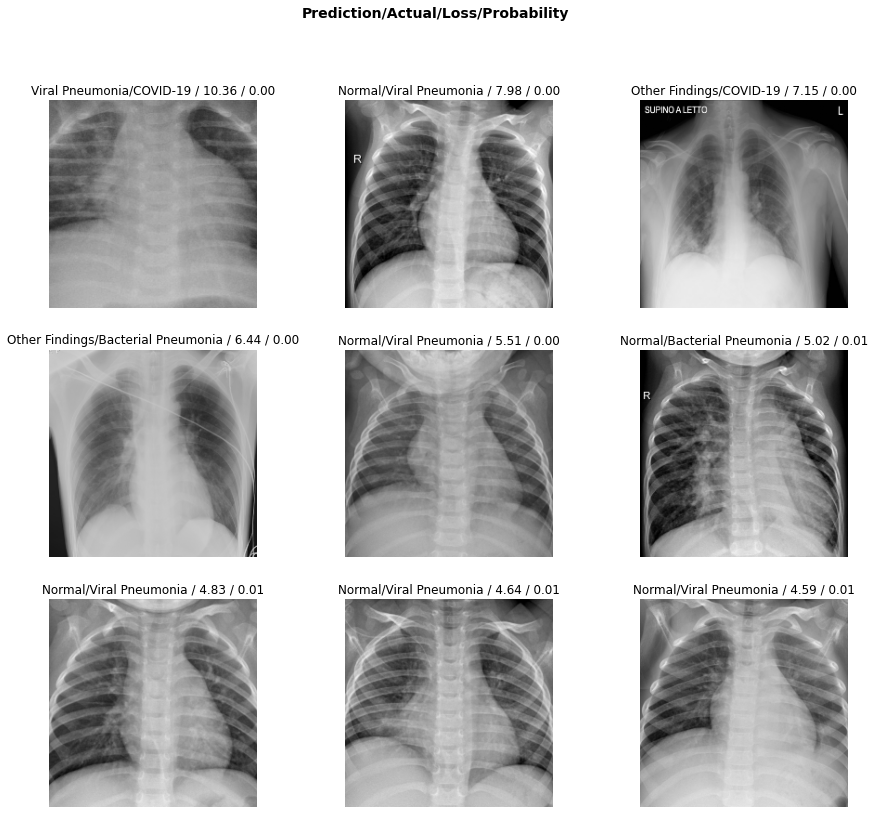

In [ ]:
interp1.plot_top_losses(9, figsize=(15,13))

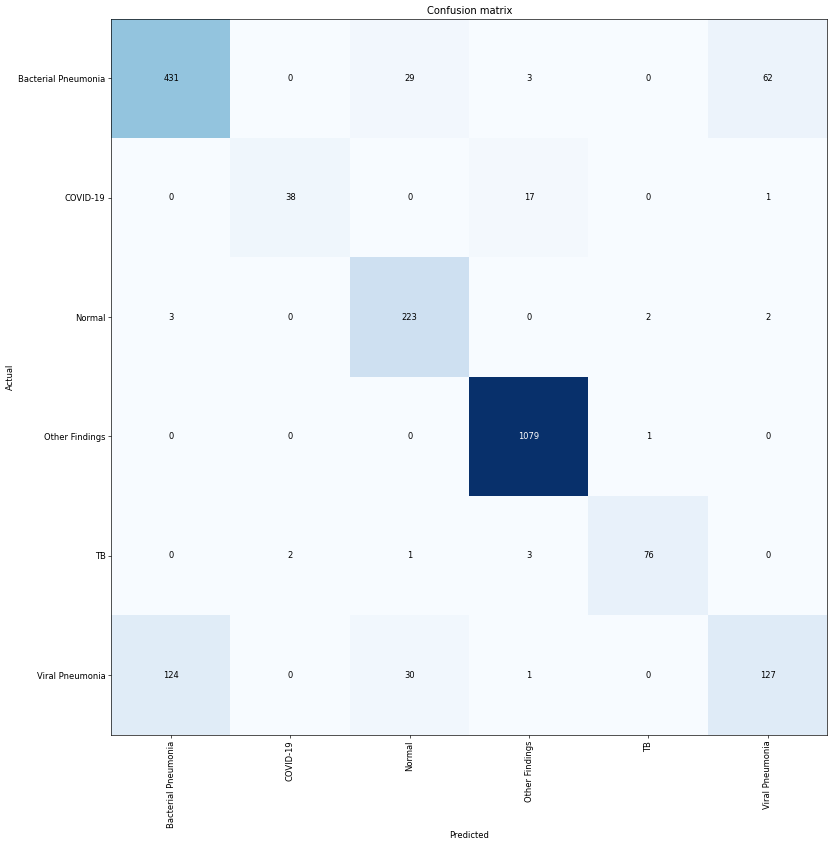

In [ ]:
interp1.plot_confusion_matrix(figsize=(14,14), dpi=60)

Our learner seems to be the most confused while classifying CXR images of pneumonia. About half of the Viral Pneumonia images are classified as Bacterial Pneumonia.

We can somewhat understand why the leaner is making so many mistakes. On a broad level, these images all belong to a single category - "X-Ray". There are very subtle differences in the images that distinguish one disease from the other. This work is actually carried by doctors and specialists who possess extensive domain knowledge. Thus, we are doing classification on a very fine level. 

Nevertheless, we will try to find ways to improve the accuracy of our model.

In [ ]:
interp1.most_confused(min_val=2)

[('Viral Pneumonia', 'Bacterial Pneumonia', 124),
 ('Bacterial Pneumonia', 'Viral Pneumonia', 62),
 ('Viral Pneumonia', 'Normal', 30),
 ('Bacterial Pneumonia', 'Normal', 29),
 ('COVID-19', 'Other Findings', 17),
 ('Bacterial Pneumonia', 'Other Findings', 3),
 ('Normal', 'Bacterial Pneumonia', 3),
 ('TB', 'Other Findings', 3),
 ('Normal', 'TB', 2),
 ('Normal', 'Viral Pneumonia', 2),
 ('TB', 'COVID-19', 2)]

Classifying a diseased image as Normal, is more dangerous than classifying normal as diseased. 

If a normal person is classified as diseased, we can verify if its true just by doing another test. But if an unhealthy person is classified as Normal, this can be disastrous. The disease of the person will go untreated.

Hence, we should try to improve the recall in detecting disease, rather than precision.

In this case, Type 2 errors in clasification are more costly.

In [ ]:
# saving the model locally
learn.export("1-8-20_4cycles.pkl")

In [ ]:
learn.save('1-8-20 4cycles 6classes')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


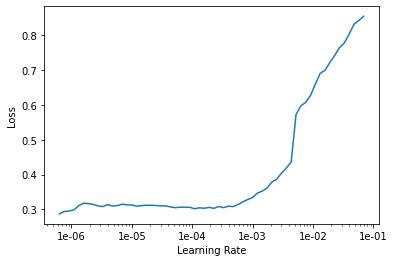

In [ ]:
learn.recorder.plot()

There is no region of steep descent in the curve.

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.314130,0.271812,0.890466,0.109534,09:19
1,0.276294,0.260244,0.894900,0.105100,09:20


In [ ]:
learn.save('1-8-20 4cycles 6classes stage 2')

In [ ]:
learn.export("1-8-20_4cycles_after_lr_find.pkl")

Next steps:
- balance the number of images in each class
- train for more epochs.

# training with 4 classes (old)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

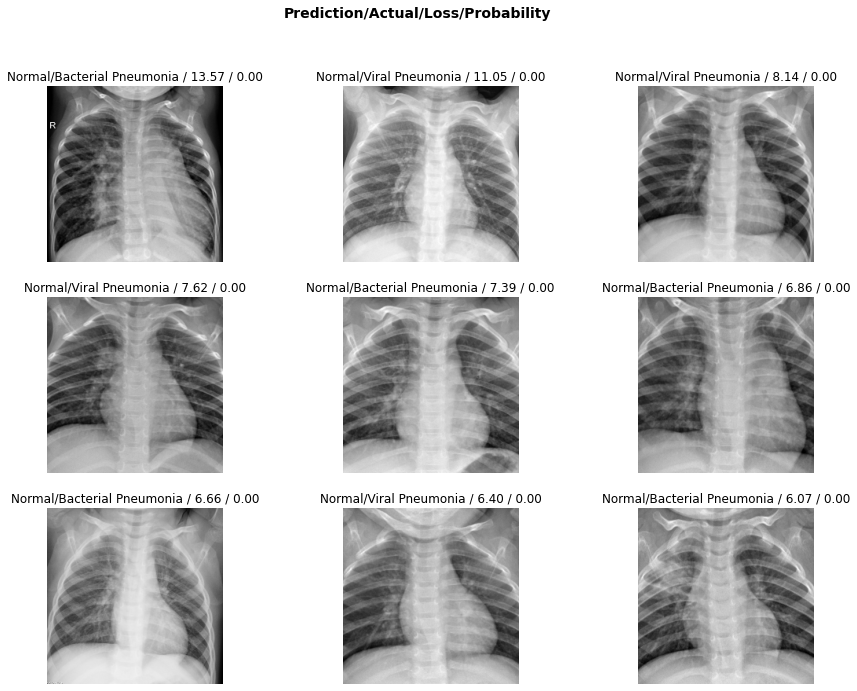

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

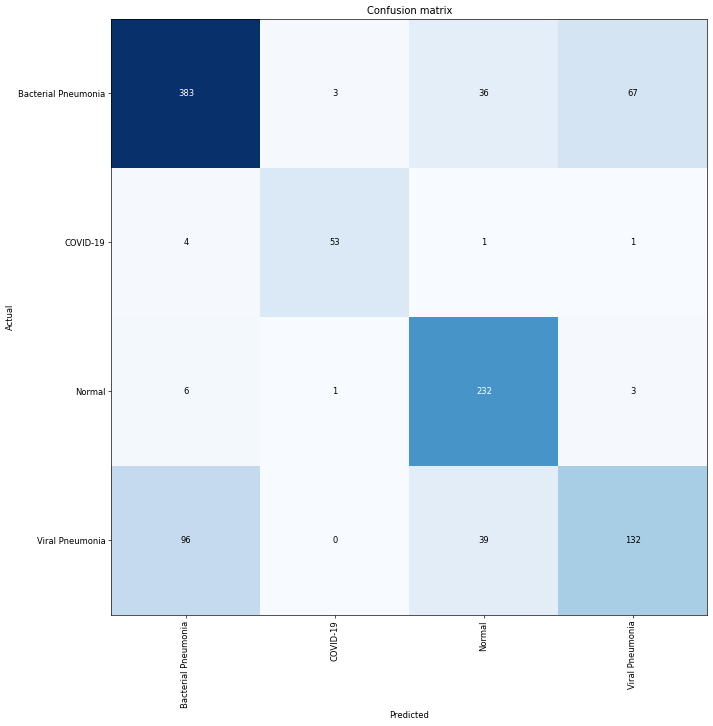

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Our learner seems to be most confused between the two categories of pneumonia. 

67 bacterial pneumonia xrays are classified as Viral pneumonia.

96 cases of viral pneumonia are classified as bacterial pneumonia.

Lets see which categories are the most confusing for our learner.

In [ ]:
interp.most_confused(min_val=2)

[('Viral Pneumonia', 'Bacterial Pneumonia', 96),
 ('Bacterial Pneumonia', 'Viral Pneumonia', 67),
 ('Viral Pneumonia', 'Normal', 39),
 ('Bacterial Pneumonia', 'Normal', 36),
 ('Normal', 'Bacterial Pneumonia', 6),
 ('COVID-19', 'Bacterial Pneumonia', 4),
 ('Bacterial Pneumonia', 'COVID-19', 3),
 ('Normal', 'Viral Pneumonia', 3)]

Let's try with 4 cycles

In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.693854,0.579769,0.770104,0.229896,04:02
1,0.665123,0.603581,0.771050,0.228950,04:04
2,0.600229,0.542341,0.781457,0.218543,04:01
3,0.564034,0.519948,0.797540,0.202460,04:04


By training for 4 cycles, we got an accuracy of 79.7%.

We have not yet reached a stage where train accuracy increases and validation accuracy decreases. Thus, we have not yet started overfitting.

In [ ]:
# save the model locally
learn.export()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

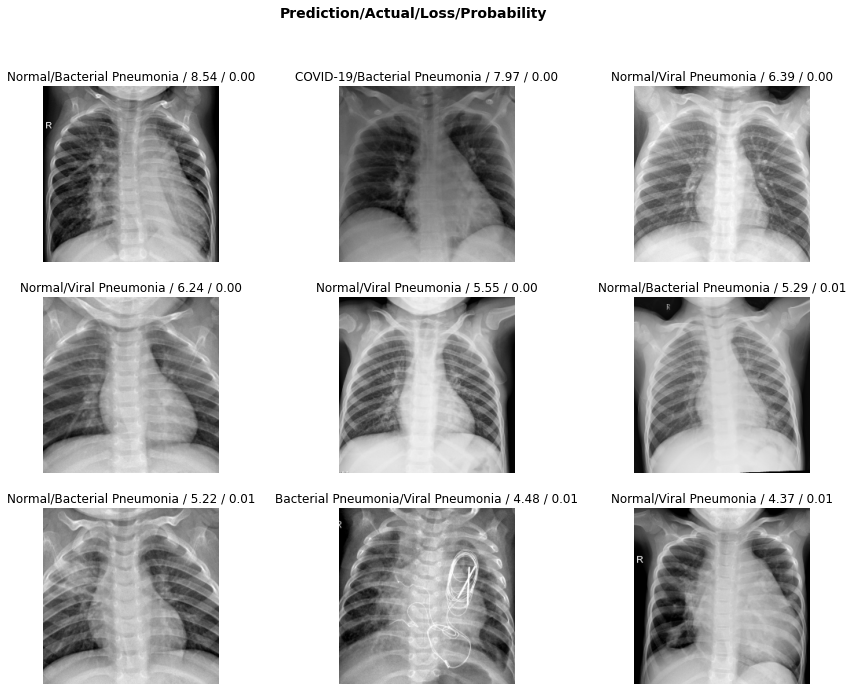

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

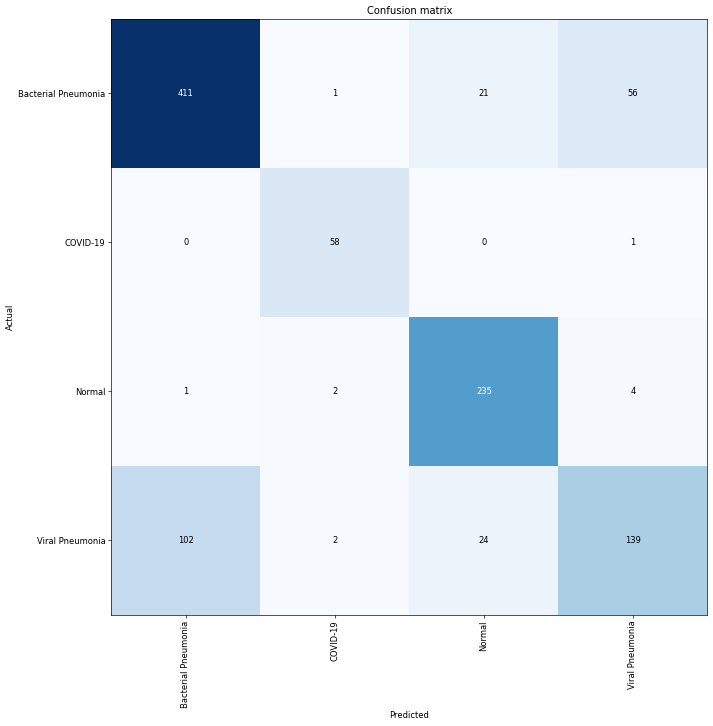

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[('Viral Pneumonia', 'Bacterial Pneumonia', 102),
 ('Bacterial Pneumonia', 'Viral Pneumonia', 56),
 ('Viral Pneumonia', 'Normal', 24),
 ('Bacterial Pneumonia', 'Normal', 21),
 ('Normal', 'Viral Pneumonia', 4),
 ('Normal', 'COVID-19', 2),
 ('Viral Pneumonia', 'COVID-19', 2)]